# Implementacion algoritmo predicción SOH
Se busca implementar el algorito de Machine Learning de Procesos Gaussianos

### Funciones para análisis de los EIS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Funciones para extraer resistencias (R) y reactancias (X).
def cycle_resistances(dataFrame):
    # Input: Txt de la base de datos de EIS Cambridge como DataFrame
    # Output: Lista con 350 listas. Cada una son los valores de resistencia
    #         de un mismo ciclo

    resistance_arrays = []
    Ns = int(dataFrame.shape[0]/60)
    for i in range(1,Ns+1):
        df1 = dataFrame[dataFrame["cycle number"]==i].copy(deep=True)
        reZ = df1["Re(Z)/Ohm"].to_list()
        resistance_arrays.append(reZ)
    return resistance_arrays

def cycle_reactances(dataFrame):
    # Input: Txt de la base de datos de EIS Cambridge como DataFrame
    # Output: Lista con 350 listas. Cada una son los valores de reactancia
    #         de un mismo ciclo
    reactance_arrays = []
    Ns = int(dataFrame.shape[0]/60)
    for i in range(1,Ns+1):
        df1 = dataFrame[dataFrame["cycle number"]==i].copy(deep=True)
        imZ = df1["-Im(Z)/Ohm"].to_list()
        reactance_arrays.append(imZ)
    return reactance_arrays

# Calculo derivada de array
def derivada_imZ(r,x):
    d = [0] 
    for i in range(len(x)-1):
        m1 = (x[i+1]-x[i])/(r[i+1]-r[i])    # dx/dr en i+1
        d.append(m1)
    return d

# Calculo segunda derivada de array
def derivada2_imZ(r,x):
    d2 = [0,0]
    for i in range(len(x)-2):
        m1 = (x[i+1]-x[i])/(r[i+1]-r[i])    # dx/dr en i+1
        m2 = (x[i+2]-x[i+1])/(r[i+2]-r[i+1])    # dx/dr en i+2
        mm2 = (m2-m1)/(r[i+2]-r[i+1])    # d2x/dr2 en i+2
        d2.append(mm2)
    return d2

#  Promedio hacia adelante
def avgs_d1(d1x):
    d1s_avg = [0,0]                 # lista que guarda los promedios
    for i in range(len(d1x)-3-2):   # calcula solo hasta 5 muestras antes del fin: no indexar mal
        avg = (d1x[i+2] + d1x[i+3] + d1x[i+4] + d1x[i+5])*0.25  # promedio 4 muestras
        d1s_avg.append(avg)
    return d1s_avg

# Algoritmo de buscar indice que ajusta mejor
def search_curve(r,x):
    # r: lista Resistencias Nyquist
    # x: lista Reactancias Nyquist
    # output: indice  
    c1 = 0                  # condicion 1
    c2 = 0                  # condicion 2
    j = 25                  # default: cortat a los 57.4 Hz
    d1 = derivada_imZ(r,x)  # Primeras derivadas
    d2 = derivada2_imZ(r,x) # Segundas derivadas
    mean4_d1 = avgs_d1(d1)  # Promedios 4 samples d1
    mean4_d2 = avgs_d1(d2)  # Promedios 4 samples d2
    # A buscar el indice
    # 1.- Buscar el indice en que el avg d1 es menor a 0.45 -> linea diagonal
    for i in range(2,30):
        if (mean4_d1[i] < 0.45):
            j = i
            c1 = 1
            break
    # 2.- A partir del indice anterior, buscar cuando avg d2 es mayor a 0 -> curva hacia arriba
    if (c1 == 1):
        for i in range(j,30):
            if (mean4_d2[i] > 0):
                j = i
                c2 = 1
                break
    return j

### Función para obtener coordenadas y radio de circunferencia
A partir de un diagrama de Nyquist.

In [33]:
from pyomo.environ import ConcreteModel, Var, Objective, SolverFactory, minimize, NonNegativeReals, Param, RangeSet
import numpy as np


def parametros_circunferencia(nyquistSamples):
    # Input: nyquistSamples lista de 2 columnas
    # Columna 0: resistencias
    # Columna 1: reactancias

    # Crear el modelo
    model = ConcreteModel()

    # Variables de decisión: coeficientes de la circunferencia
    model.p1 = Var()    # theta 1
    model.p2 = Var()    # theta 2
    model.p3 = Var()    # theta 3

    # Conjunto de puntos
    N = len(nyquistSamples)
    model.i = RangeSet(N)

    # Parámetros: coordenadas de los puntos
    model.r = Param(model.i, initialize=lambda model, i: nyquistSamples[i-1, 0])    # i e [1, 2, 3, ..., N]
    model.x = Param(model.i, initialize=lambda model, i: nyquistSamples[i-1, 1])    # indexacion como en Matlab/Julia

    # Función objetivo: Minimizar la suma de los cuadrados de las diferencias (residuos)
    def objective_rule(model):
        return sum((model.r[i]**2 + model.x[i]**2 + model.p1*model.r[i] + model.p2*model.x[i] + model.p3)**2 for i in model.i)

    model.obj = Objective(rule=objective_rule, sense=minimize)  # incluir FO en modelo - minimizar

    # Resolver el problema
    solver = SolverFactory('gurobi')  # Puedes usar cualquier solver compatible, por ejemplo 'glpk'
    solver.solve(model, tee=True)

    # Calcular el centro y el radio de la circunferencia
    cx = -model.p1() / 2
    cy = -model.p2() / 2
    r = np.sqrt(model.p1()**2 + model.p2()**2 - 4*model.p3()) / 2

    parametros = {"cx":cx, "cy":cy, "r":r}
    return parametros



### Lectura de archivos CSV como DataFrames

In [36]:
# Leer datos
eis_soc1 = pd.read_csv("EIS_state_I_25C05.csv",sep=',', header=0, index_col=False)
eis_soc2 = pd.read_csv("EIS_state_II_25C05.csv",sep=',', header=0, index_col=False)
eis_soc3 = pd.read_csv("EIS_state_III_25C05.csv",sep=',', header=0, index_col=False)
eis_soc4 = pd.read_csv("EIS_state_IV_25C05.csv",sep=',', header=0, index_col=False)
eis_soc5 = pd.read_csv("EIS_state_V_25C05.csv",sep=',', header=0, index_col=False)
eis_soc6 = pd.read_csv("EIS_state_VI_25C05.csv",sep=',', header=0, index_col=False)
#eis_soc7 = pd.read_csv("EIS_state_VII_25C05.csv",sep=',', header=0, index_col=False)
#eis_soc8 = pd.read_csv("EIS_state_VIII_25C05.csv",sep=',', header=0, index_col=False)
#eis_soc9 = pd.read_csv("EIS_state_IX_25C05.csv",sep=',', header=0, index_col=False)

# Resistencias y reactancias para Nyquist
# SOC 1
r_soc1 = cycle_resistances(eis_soc1)
x_soc1 = cycle_reactances(eis_soc1)
# SOC 2
r_soc2 = cycle_resistances(eis_soc2)
x_soc2 = cycle_reactances(eis_soc2)
# SOC 3
r_soc3 = cycle_resistances(eis_soc3)
x_soc3 = cycle_reactances(eis_soc3)
# SOC 4
r_soc4 = cycle_resistances(eis_soc4)
x_soc4 = cycle_reactances(eis_soc4)
# SOC 5
r_soc5 = cycle_resistances(eis_soc5)
x_soc5 = cycle_reactances(eis_soc5)
# SOC 6
r_soc6 = cycle_resistances(eis_soc6)
x_soc6 = cycle_reactances(eis_soc6)
# SOC 7
#r_soc7 = cycle_resistances(eis_soc7)
#x_soc7 = cycle_reactances(eis_soc7)
# SOC 8
#r_soc8 = cycle_resistances(eis_soc8)
#x_soc8 = cycle_reactances(eis_soc8)
# SOC 9
#r_soc9 = cycle_resistances(eis_soc9)
#x_soc9 = cycle_reactances(eis_soc9)

# r_soci = [Nyquist_ciclo1, Nyquist_ciclo2, ..., Nyquist_cicloN]
# x_soci = [Nyquist_ciclo1, Nyquist_ciclo2, ..., Nyquist_cicloN]
# N: el número de ciclos de la batería C04 a 25°C en el estado i.

### Cortar las primeras 13 muestras de un diagrama de Nyquist

In [37]:
def nyquist_cut(cycle, cycleRs, cycleXs):
    # Rescata las primeras 13 muestras: hasta 1200 Hz
    cut = 13    # indice donde corta (0-12)

    points = np.zeros(shape=(cut,2))    # Matrix para guardar samples
    for i in range(cut):
        points[i,0] = cycleRs[cycle][i] # agregar resistencia del ciclo y de la frecuencia
        points[i,1] = cycleXs[cycle][i] # agregar reactancia del ciclo y de la frecuencia

    return points 

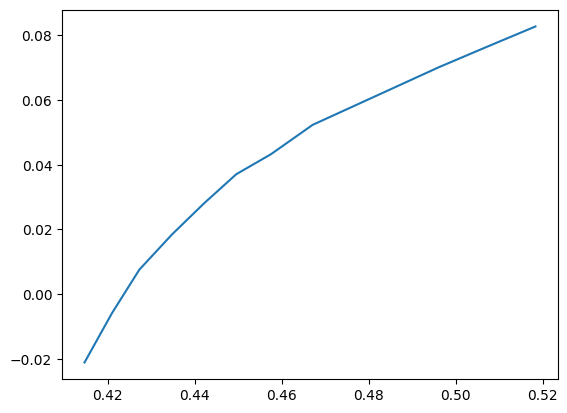

In [38]:
prueba = nyquist_cut(50, r_soc5, x_soc5)
plt.plot(prueba[:,0],prueba[:,1])

In [39]:
diccionario = parametros_circunferencia(prueba)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-26
Read LP format model from file C:\Users\sevil\AppData\Local\Temp\tmp4v6f4_dh.pyomo.lp
Reading time = 0.01 seconds
x1: 1 rows, 4 columns, 1 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 4 columns and 1 nonzeros
Model fingerprint: 0x5940444c
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 6e+00]
  QObjective range [6e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 0 rows, 3 columns, 0 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statisti

### Sacar la capacidad real de la bateria
Problema: hay muchas mediciones para un mismo ciclo.
Solucion: se calcula la capacidad máxima por ciclo. Luego el estado 5 corresponde a la carga al 100%.

In [41]:
cap_c5 = pd.read_csv("Data_Capacity_25C05.csv",sep=',', header=0, index_col=False)

In [48]:
type(cap_c5.iloc[0,1])

numpy.float64

In [52]:
cap_c5

,time/s,cycle number,ox/red,Capacity/mA.h
0,0.000000e+00,0.0,1,0.000000
1,2.000000e-04,0.0,1,0.000003
2,4.000000e-04,0.0,1,0.000005
3,8.000000e-04,0.0,1,0.000010
4,1.200000e-03,0.0,1,0.000015
...,...,...,...,...
627650,4.228293e+06,328.0,1,2.690540
627651,4.228303e+06,328.0,1,2.715155
627652,4.228306e+06,328.0,1,2.721403
627653,4.229806e+06,328.0,1,2.721403


### Mejorar este algoritmo para sacar las CAPACIDADES

In [55]:
# OJO CON ESTE ALGORITMO
max_cap = []                        # Guardar la máxima capacidad por ciclo
max  = cap_c5.iloc[0,3]             # Condicion inicial maximo
for i in range(1, cap_c5.shape[0]):    # Recorrer desde la segunda hasta el final de mediciones de capacidad de bateria
    cap = cap_c5.iloc[i,3]      # capacidad de la medicion i
    if cap > max:
        max = cap
    if ((cap_c5.iloc[i,1] - cap_c5.iloc[i-1,1]) > 0):     # Comparar ciclo de i con ciclo de i-1
        max_cap.append(max)


Algoritmo menos complejo:

In [60]:
max_cap = []                        # Guardar la máxima capacidad por ciclo
max  = cap_c5.iloc[0,3]             # Condicion inicial maximo
for i in range(cap_c5.shape[0]):    # Recorrer el DF
    if ((cap_c5.iloc[i,1] - cap_c5.iloc[i-1,1]) > 0):     # Comparar ciclo de i con ciclo de i-1
        max_cap.append(cap_c5.iloc[i-1,3])
        

### Crear matrix para entrenar datos

In [73]:
entradas_geo = np.zeros((len(r_soc5),3))

for i in range(len(r_soc5)):        # recorrer todos los nyquist (ciclos)
    # Tomar muestras del diagrama de nyquist y ajustar circunferencia
    samples_nyquist = nyquist_cut(i, r_soc5, x_soc5)            # tomar las 13 primeras muestras del diagrama
    parametros = parametros_circunferencia(samples_nyquist)     # ajustar circunferencia: sacar coordenadas y el radio

    # Agregar parametros geometricos a la fila i
    entradas_geo[i,0] = parametros["cx"]
    entradas_geo[i,1] = parametros["cy"]
    entradas_geo[i,2] = parametros["r"]


Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-26
Read LP format model from file C:\Users\sevil\AppData\Local\Temp\tmpohly_6tz.pyomo.lp
Reading time = 0.01 seconds
x1: 1 rows, 4 columns, 1 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 4 columns and 1 nonzeros
Model fingerprint: 0x2e9e28cd
Model has 6 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 4e+00]
  QObjective range [6e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 0 rows, 3 columns, 0 nonzeros
Presolved model has 6 quadratic objective terms
Ordering time: 0.00s

Barrier statisti

In [74]:
salidas_cap = np.zeros((len(r_soc5),1))
for i in range(len(r_soc5)):
    salidas_cap[i,0] = max_cap[i]

### Observar las circunferencias
Gentileza de OpenAI.
- Nyquist de estado 5 (carga completa).
- Estado de carga medido justo antes de comenzar un nuevo ciclo.
- Batería C05 a 25°C constantes.

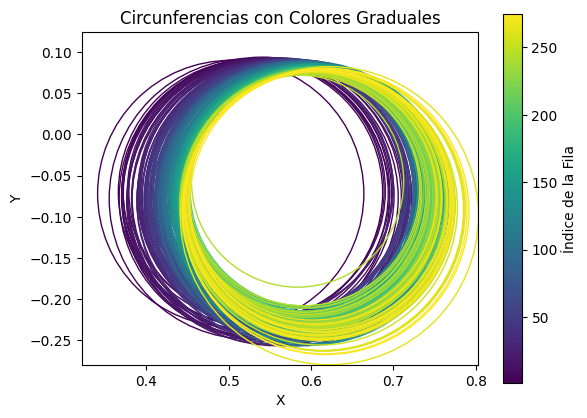

In [72]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

# Supongamos que tu matriz se llama 'data' y es de tamaño 275x3
# data = np.array([[x1, y1, r1], [x2, y2, r2], ..., [x275, y275, r275]])
# Como ejemplo, voy a generar una matriz aleatoria
np.random.seed(0)
data = entradas_geo

# Crear una figura y un eje
fig, ax = plt.subplots()

# Usar un colormap para asignar colores
colormap = cm.viridis
num_circles = data.shape[0]
colors = colormap(np.linspace(0, 1, num_circles))

# Graficar cada circunferencia con un color diferente
for i in range(num_circles):
    x, y, r = data[i]
    color = colors[i]
    circ = plt.Circle((x, y), r, edgecolor=color, facecolor='none')
    ax.add_patch(circ)

# Ajustar los límites del gráfico
ax.set_xlim(data[:,0].min() - data[:,2].max(), data[:,0].max() + data[:,2].max())
ax.set_ylim(data[:,1].min() - data[:,2].max(), data[:,1].max() + data[:,2].max())

# Configurar el aspecto del gráfico
ax.set_aspect('equal', 'box')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Circunferencias con Colores Graduales')

# Crear una barra de color
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=1, vmax=num_circles))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Índice de la Fila')

# Mostrar el gráfico
plt.show()



### Capacidad respecto a parámetros
Cortesía de OpenAI

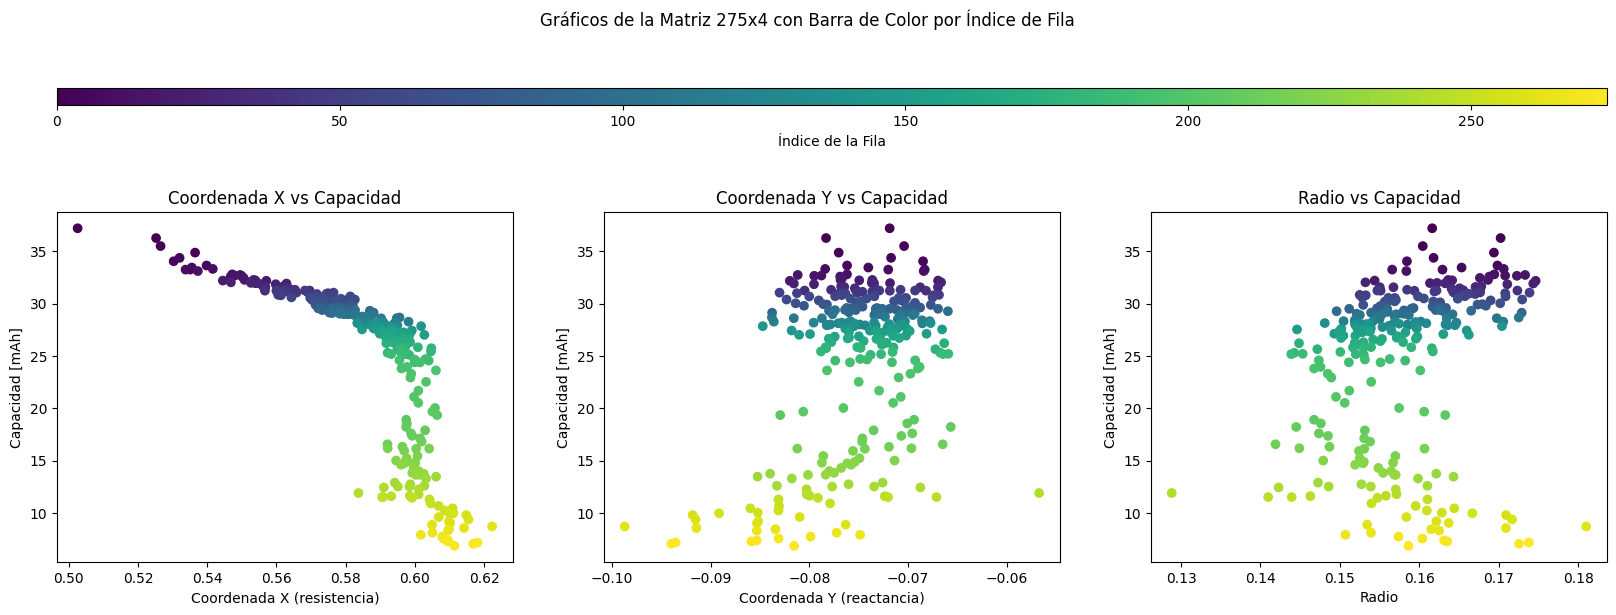

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

# Supongamos que tu matriz se llama 'data' y es de tamaño 275x4
# data = np.array([[x1, y1, r1, v1], [x2, y2, r2, v2], ..., [x275, y275, r275, v275]])
np.random.seed(0)
data = entradas_geo
salida = salidas_cap

# Crear una figura con una cuadrícula de subparcelas (GridSpec)
fig = plt.figure(figsize=(20, 8))  # Aumentar el tamaño de la figura para acomodar la barra de color
gs = GridSpec(3, 3, height_ratios=[0.1, 0.05, 1], hspace=0.8)  # Crear una cuadrícula con espacio para la barra de color

# Títulos de los gráficos
titles = ['Coordenada X vs Capacidad', 'Coordenada Y vs Capacidad', 'Radio vs Capacidad']
etiquetasX = ["Coordenada X (resistencia)", "Coordenada Y (reactancia)", "Radio"]

# Usar un colormap para asignar colores
colormap = cm.viridis
num_rows = data.shape[0]
colors = colormap(np.linspace(0, 1, num_rows))

# Graficar los datos en cada subgráfico
for i in range(3):
    ax = fig.add_subplot(gs[2, i])
    sc = ax.scatter(data[:, i], salida[:, 0], c=np.arange(num_rows), cmap=colormap)
    ax.set_xlabel(etiquetasX[i])
    ax.set_ylabel('Capacidad [mAh]')
    ax.set_title(titles[i])

# Crear una barra de color compartida para los tres gráficos, ubicada en la segunda fila de la cuadrícula
cbar_ax = fig.add_subplot(gs[1, :])
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Índice de la Fila')

# Configurar la figura
fig.suptitle('Gráficos de la Matriz 275x4 con Barra de Color por Índice de Fila', y=0.8)  # Ajustar la posición del título
plt.show()


## Regresion: SciLearn-Kit

- Entradas X: entradas_geo = [X, Y, R] - parámetros geométricos de la circunferencia ajustada desde Nyquist
- Salidas Y: salidas_cap = [mAh] - capacidad de carga de la batería

### Tomar data train-test
Se toman 225 muestras aleatorias

In [80]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(entradas_geo.shape[0]), size=225, replace=False)    # 225/275 muestras    
X_train, y_train = entradas_geo[training_indices], salidas_cap[training_indices]

In [82]:
len(X_train)

225

In [202]:
X = entradas_geo
y = salidas_cap

### Kernel: RBF
La publicación estudiada utiliza este Kernel. Large lentgh-scale (l) -> más grande = más suave

In [205]:
from sklearn.gaussian_process.kernels import RBF
kernel_soc = 50.0**2 * RBF(length_scale=50.0)

La amplificación y valor inicial son hyperparámetros. Sin embargo, luego el modelo va ajustando el sigma y el l. Los valores inciales de este caso corresponden al ejemplo de la documentación: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py

### Ajustar datos al modelo
Se ajusta el offset de los datos de salida en cero.

In [206]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=kernel_soc, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

c:\Users\sevil\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50))

In [203]:
y.mean()

24.69626081312105